In [2]:
library(Seurat)
library(Signac)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)



In [ ]:
# filter rna first then 
# add in histone assay with the same cells as the histone
# filter rna for cells in the histone 
# cluster

In [3]:
Sys.time()
H3K27ac_counts_RNA_NEW <- Read10X_h5("/projects/ps-epigen/10x_output/231025_IGM/counts_out/Multiome/QY_2223_1_2_QY_2222_1_2/outs/raw_feature_bc_matrix.h5")
Sys.time()

[1] "2023-11-08 08:26:40 PST"

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' is deprecated; setting repr="T" for you"
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").

Genome matrix has multiple modalities, returning a list of matrices for this genome



[1] "2023-11-08 08:26:55 PST"

In [4]:
H3K27ac_fragpath <- "/projects/ps-epigen/10x_output/231025_IGM/counts_out/Multiome/QY_2223_1_2_QY_2222_1_2/outs/atac_fragments.tsv.gz"
genome.use <- seqlengths(BSgenome.Mmusculus.UCSC.mm10::BSgenome.Mmusculus.UCSC.mm10) 
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79, verbose = F)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [5]:
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
#Seurat Object for RNA data
H3K27ac_CT_RNA_Multiome <- CreateSeuratObject( counts = H3K27ac_counts_RNA_NEW$`Gene Expression`, assay = "RNA",
 min.features = 1,
  min.cells = 1
)


In [6]:
H3K27ac_CT_RNA_Multiome

An object of class Seurat 
26496 features across 645429 samples within 1 assay 
Active assay: RNA (26496 features, 0 variable features)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



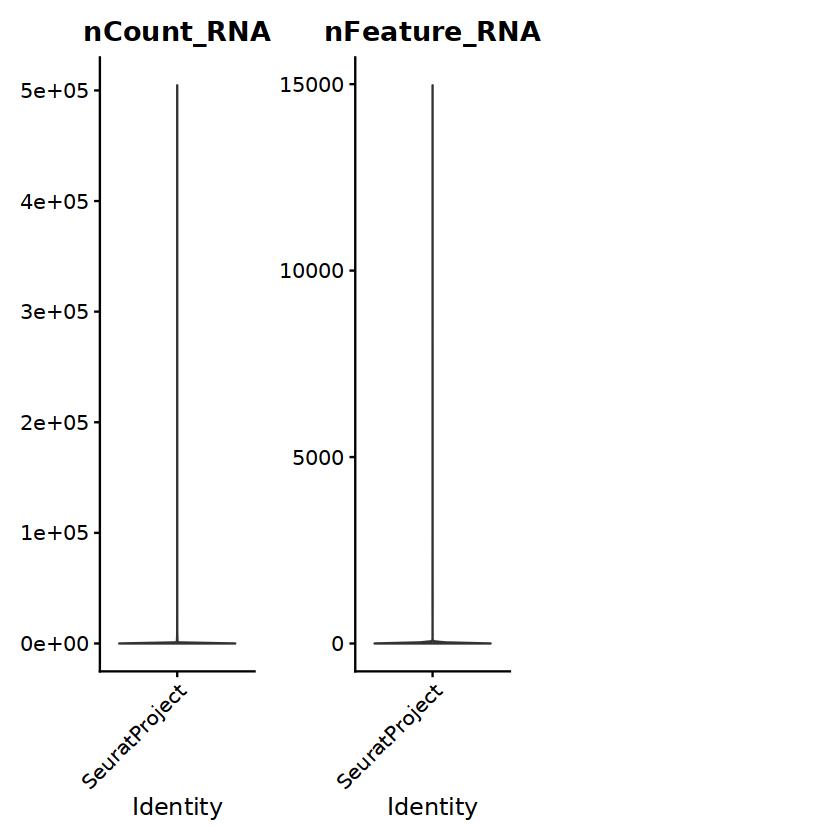

In [7]:
VlnPlot(H3K27ac_CT_RNA_Multiome , c("nCount_RNA", "nFeature_RNA"), ncol = 4,
       pt.size = 0)

In [8]:
H3K27ac_CT_RNA_Multiome[["percent.mt"]] <- PercentageFeatureSet(H3K27ac_CT_RNA_Multiome, pattern = "^mt-", assay = "RNA")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



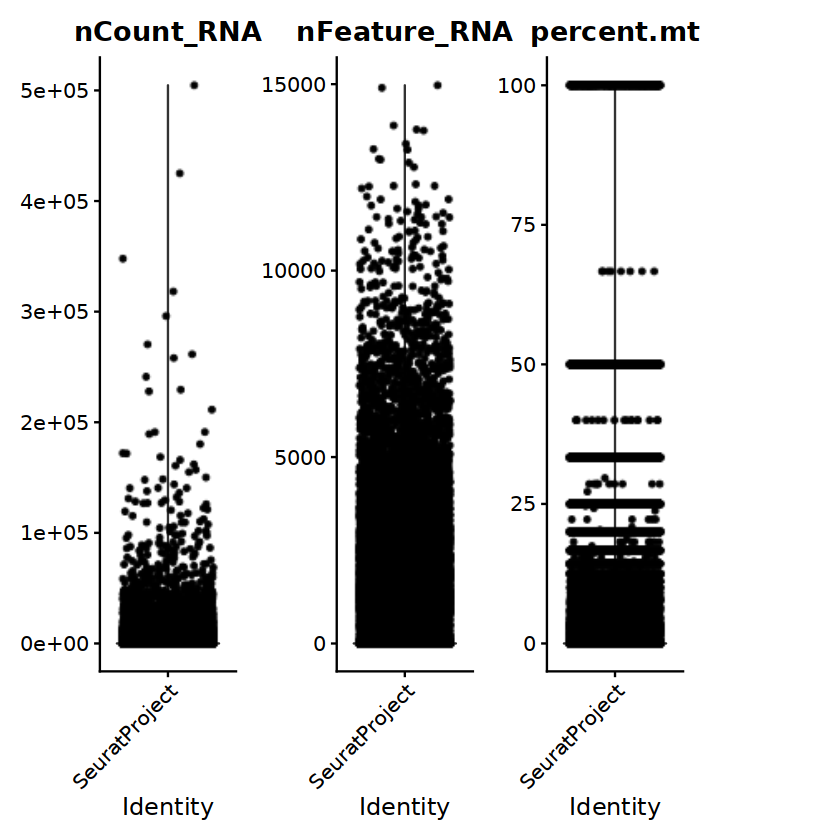

In [9]:
VlnPlot(H3K27ac_CT_RNA_Multiome , c("nCount_RNA", "nFeature_RNA", "percent.mt"), ncol = 4,
       pt.size = 1)

In [10]:
quantile(H3K27ac_CT_RNA_Multiome$nCount_RNA)
quantile(H3K27ac_CT_RNA_Multiome$nFeature_RNA)
quantile(H3K27ac_CT_RNA_Multiome$percent.mt)
# missing values and NaN's not allowed if 'na.rm' is FALSE percent.mt probs due to empty droplets

0%    25%    50%    75%   100% 
     1      2      3      6 504653

0%   25%   50%   75%  100% 
    1     2     3     6 14970

0%  25%  50%  75% 100% 
   0    0    0    0  100

In [11]:
# filter rna first before adding histon
filt_obj_H3K27ac <- subset(H3K27ac_CT_RNA_Multiome, nCount_RNA > 100
                     & nFeature_RNA > 100 
                     & percent.mt < 10)

In [12]:
filt_obj_H3K27ac 

An object of class Seurat 
26496 features across 20573 samples within 1 assay 
Active assay: RNA (26496 features, 0 variable features)

In [13]:
filt_obj_H3K27ac[["percent.mt"]] <- PercentageFeatureSet(filt_obj_H3K27ac , pattern = "^mt-", assay = "RNA")

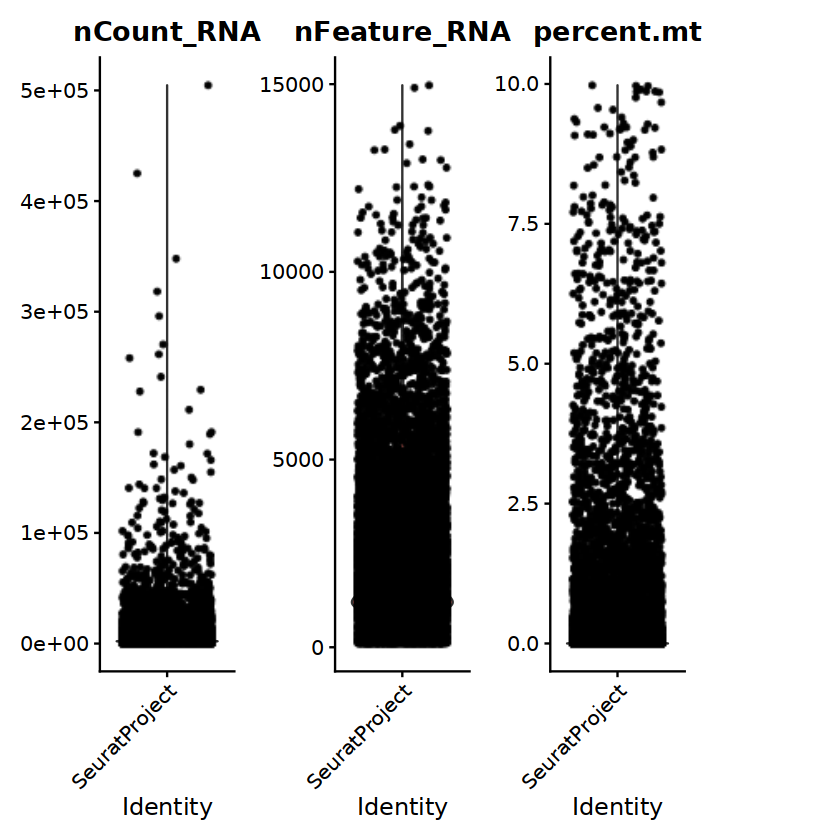

In [14]:
VlnPlot(filt_obj_H3K27ac, c("nCount_RNA", "nFeature_RNA", "percent.mt"), ncol = 4,
       pt.size = 1)

In [15]:
# Cellbarcodes RNA data
# add the atac
H3K27ac_cells_RNA <- colnames(filt_obj_H3K27ac )

In [16]:
H3K27ac_fragments_Multiome <- CreateFragmentObject(path = H3K27ac_fragpath, cells = H3K27ac_cells_RNA,
                                           verbose = TRUE,validate.fragments = TRUE)

Computing hash



In [17]:
H3K27ac_fragments_Multiome 

A Fragment object for 20573 cells

In [19]:
cts_pks <- H3K27ac_counts_RNA_NEW$Peaks[,H3K27ac_cells_RNA]
dim(cts_pks)

[1] 71538 20573

In [20]:
H3K27ac_CT_Multiome.assay <- CreateChromatinAssay( counts = cts_pks,
  sep = c(":", "-"),
  min.features = 1,
  min.cells = 1,
  annotation = annotations,
  fragments = H3K27ac_fragpath
)

Computing hash



In [21]:
dim(H3K27ac_CT_Multiome.assay )

[1] 71449 19835

In [22]:
H3K27ac_CT_RNA_Multiome


An object of class Seurat 
26496 features across 645429 samples within 1 assay 
Active assay: RNA (26496 features, 0 variable features)

In [23]:
H3K27ac_CT_Multiome.assay


ChromatinAssay data with 71449 features for 19835 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [24]:
filt_obj_H3K27ac 

An object of class Seurat 
26496 features across 20573 samples within 1 assay 
Active assay: RNA (26496 features, 0 variable features)

In [25]:
# whats in the rna thats not in the histone
head(setdiff(colnames(filt_obj_H3K27ac ), colnames(H3K27ac_CT_Multiome.assay)))
length(setdiff(colnames(filt_obj_H3K27ac ), colnames(H3K27ac_CT_Multiome.assay)))

[1] "AAACAGCCAGAATGAC-1" "AAACCGAAGATGGACA-1" "AAACCGAAGGAAGTAT-1"
[4] "AAACGCGCACCAGGTT-1" "AAACGGATCATGTCAA-1" "AAAGCAAGTGTGTCCC-1"

[1] 738

In [26]:
grep('AAACAGCCAGAATGAC-1', rownames(filt_obj_H3K27ac@meta.data))

[1] 9

In [27]:
# this cell isnt present in the histone
grep('AAACAGCCAGAATGAC-1', colnames(H3K27ac_CT_Multiome.assay))

integer(0)

In [28]:
head(filt_obj_H3K27ac@meta.data, 9)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACAGCCAACTAGCC-1,SeuratProject,33547,7020,0.10135034
AAACAGCCAAGGCCAA-1,SeuratProject,9312,3046,0.01073883
AAACAGCCAAGGTATA-1,SeuratProject,1582,968,0.00000000
AAACAGCCAATTAAGG-1,SeuratProject,1821,1116,0.05491488
AAACAGCCAATTGCGC-1,SeuratProject,5819,2726,0.00000000
AAACAGCCACAGGATG-1,SeuratProject,3574,1823,0.02797985
AAACAGCCACGCAACT-1,SeuratProject,6607,2488,0.00000000
AAACAGCCACGTGCTG-1,SeuratProject,24887,6330,0.02009081
AAACAGCCAGAATGAC-1,SeuratProject,278,260,0.00000000


In [29]:
dim(H3K27ac_CT_Multiome.assay)

[1] 71449 19835

In [30]:
# maybe subset the rna for the cells in the histone

filt_obj_H3K27ac <- subset(filt_obj_H3K27ac, cells = colnames(H3K27ac_CT_Multiome.assay)) 

In [31]:
# now same number of cells as the histone
filt_obj_H3K27ac

An object of class Seurat 
26496 features across 19835 samples within 1 assay 
Active assay: RNA (26496 features, 0 variable features)

In [32]:
# create histone assay and add it to the object
filt_obj_H3K27ac[["H3K27ac"]] <- H3K27ac_CT_Multiome.assay

In [33]:
filt_obj_H3K27ac

An object of class Seurat 
97945 features across 19835 samples within 2 assays 
Active assay: RNA (26496 features, 0 variable features)
 1 other assay present: H3K27ac

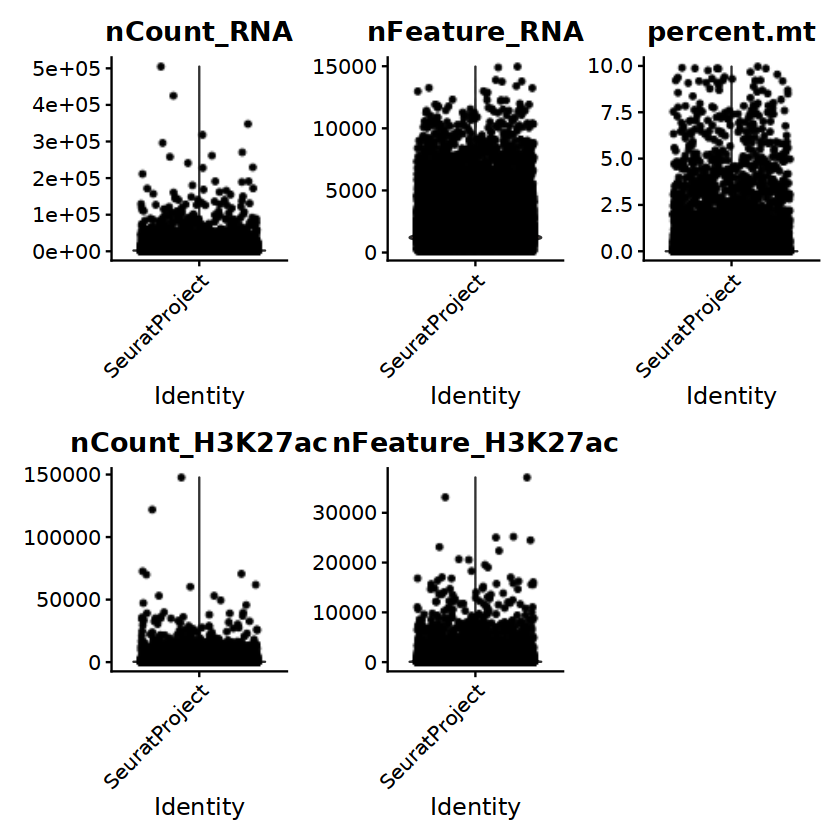

In [34]:
VlnPlot(filt_obj_H3K27ac, c("nCount_RNA", "nFeature_RNA", "percent.mt", "nCount_H3K27ac", "nFeature_H3K27ac"), ncol = 3,
       pt.size = 1)

In [ ]:
# choose not to filter the histone

In [35]:
filt_obj_H3K27ac$library_rna_atac_id <- "QY_2223_1_2_QY_2222_1_2"

In [36]:
head(filt_obj_H3K27ac@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_H3K27ac,nFeature_H3K27ac,library_rna_atac_id
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>
AAACAGCCAACTAGCC-1,SeuratProject,33547,7020,0.10135034,4383,2664,QY_2223_1_2_QY_2222_1_2
AAACAGCCAAGGCCAA-1,SeuratProject,9312,3046,0.01073883,409,262,QY_2223_1_2_QY_2222_1_2
AAACAGCCAAGGTATA-1,SeuratProject,1582,968,0.00000000,194,119,QY_2223_1_2_QY_2222_1_2
AAACAGCCAATTAAGG-1,SeuratProject,1821,1116,0.05491488,305,199,QY_2223_1_2_QY_2222_1_2
AAACAGCCAATTGCGC-1,SeuratProject,5819,2726,0.00000000,636,399,QY_2223_1_2_QY_2222_1_2
AAACAGCCACAGGATG-1,SeuratProject,3574,1823,0.02797985,547,342,QY_2223_1_2_QY_2222_1_2


In [37]:
dir.create('/projects/ps-epigen/users/cmiciano/Lung/lungmap_3/04_paired_tag_deepseq_filt_objs/')

Warning message in dir.create("/projects/ps-epigen/users/cmiciano/Lung/lungmap_3/04_paired_tag_deepseq_filt_objs/"):
"'/projects/ps-epigen/users/cmiciano/Lung/lungmap_3/04_paired_tag_deepseq_filt_objs' already exists"


In [38]:
Sys.time()
filt_obj_H3K27ac <- NormalizeData(filt_obj_H3K27ac, normalization.method = "LogNormalize", scale.factor = 10000)
filt_obj_H3K27ac <- FindVariableFeatures(filt_obj_H3K27ac, selection.method = "vst", nfeatures = 2000)
filt_obj_H3K27ac <- ScaleData(filt_obj_H3K27ac)
filt_obj_H3K27ac <- RunPCA(filt_obj_H3K27ac, features = VariableFeatures(object = filt_obj_H3K27ac), verbose = F)
filt_obj_H3K27ac <- FindNeighbors(filt_obj_H3K27ac, dims = 1:50)
filt_obj_H3K27ac <- FindClusters(filt_obj_H3K27ac, resolution = 0.5)
filt_obj_H3K27ac <- RunUMAP(filt_obj_H3K27ac, dims = 1:50, verbose = F)
Sys.time()


[1] "2023-11-08 08:31:52 PST"

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19835
Number of edges: 989654

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9493
Number of communities: 29
Elapsed time: 3 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


[1] "2023-11-08 08:32:51 PST"

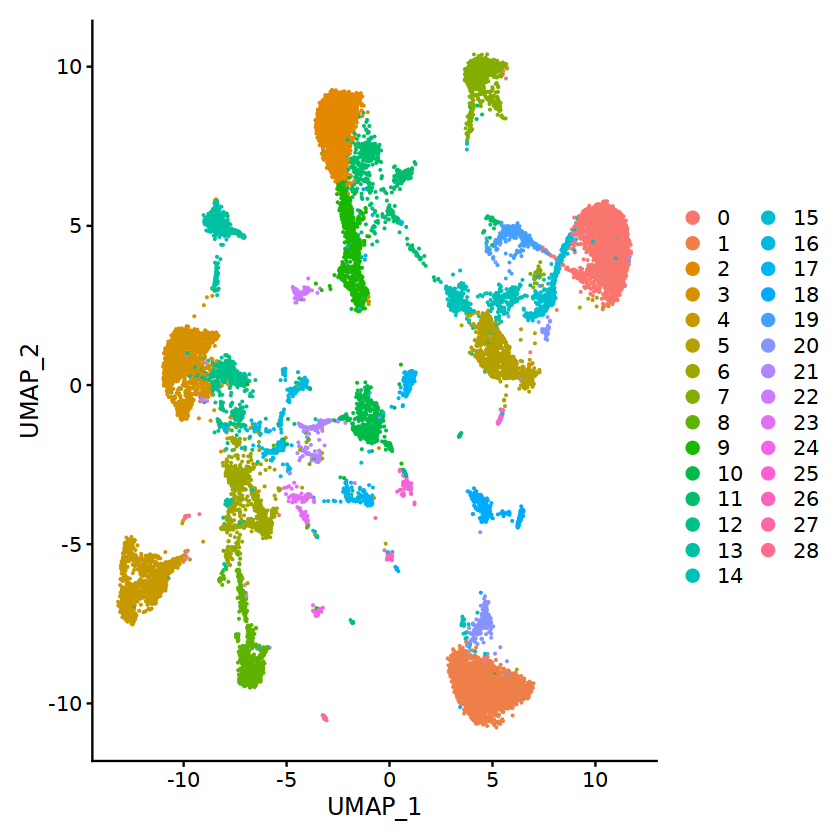

In [40]:
DimPlot(filt_obj_H3K27ac)

In [41]:
Sys.time()
saveRDS(filt_obj_H3K27ac , "/projects/ps-epigen/users/cmiciano/Lung/lungmap_3/04_paired_tag_deepseq_filt_objs/QY_2223_1_2_QY_2222_1_2.RDS")
Sys.time()

[1] "2023-11-08 08:34:03 PST"

[1] "2023-11-08 08:35:10 PST"

In [42]:
filt_obj_H3K27ac <- readRDS("/projects/ps-epigen/users/cmiciano/Lung/lungmap_3/04_paired_tag_deepseq_filt_objs/QY_2223_1_2_QY_2222_1_2.RDS")


In [43]:
filt_obj_H3K27ac

An object of class Seurat 
97945 features across 19835 samples within 2 assays 
Active assay: RNA (26496 features, 2000 variable features)
 1 other assay present: H3K27ac
 2 dimensional reductions calculated: pca, umap